In [2]:
import pandas as pd
import sklearn
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

# WiDS datathon 2022 

The WiDS Datathon 2022 focuses on a prediction task involving roughly **100k** observations of **building energy usage records** collected over **7 years** and a **number of states** within the United States.

The dataset consists of:
- building characteristics (e.g. floor area, facility type etc.), 
- weather data for the location of the building (e.g. annual average temperature, annual total precipitation etc.) 
- __target__: **Site Energy Usage Intensity** (Site EUI), i.e. total energy usage in one year, divided by the building floor area

$$\frac{total\,energy\,in\,one\,year}{floor\,area}$$
  
Each __row__ in the data corresponds to the a **single building** observed **in a given year**. 

Your task is to **predict the Site EUI for each row**, given the characteristics of the building and the weather data for the location of the building.




## Description of the dataset

### Features

The list of features with a code prepended: 
- *C* for 'expected correlated'
- *U* for 'expected uncorrelated'

- *CAT* for 'categorical'
- *NUM* for 'numerical'

#### Building Characteristics
(U)(NUM) `id`: building id

(C)(NUM) `Year_Factor`: anonymized year in which the weather and energy usage factors were observed

(C)(CAT) `State_Factor`: anonymized state in which the building is located

(C)(CAT) `building_class`: building classification (commercial/residential)

(C)(CAT) `facility_type`: building usage type (e.g. office, hotel, shopping center...)

(C)(NUM) `floor_area`: floor area (in square feet) of the building

(C)(NUM) `year_built`: year in which the building was constructed

(C)(NUM) `energy_star_rating`: the energy star rating of the building (in terms of energy efficiency)

(C)(NUM) `ELEVATION`: elevation of the building location

#### Weather Characteristics

(C)(NUM) `january_min_temp`: minimum temperature in January (in Fahrenheit) at the location of the building (and repeated for all months)

(C)(NUM) `january_avg_temp`: average temperature in January (in Fahrenheit) at the location of the building (and repeated for all months)

(C)(NUM) `january_max_temp`: maximum temperature in January (in Fahrenheit) at the location of the building (and repeated for all months)

(C)(NUM) `cooling_degree_days`: cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit (~18° C). Each month is summed to produce an **annual total** at the location of the building.

(C)(NUM) `heating_degree_days`: heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit (~18° C). Each month is summed to produce an **annual total** at the location of the building.

(C)(NUM) `precipitation_inches`: annual precipitation in inches at the location of the building

(C)(NUM) `snowfall_inches`: annual snowfall in inches at the location of the building

(C)(NUM) `snowdepth_inches`: annual snow depth in inches at the location of the building

(C)(NUM) `avg_temp`: average temperature over a year at the location of the building

(C)(NUM) `days_below_30F`: total number of days below 30 degrees Fahrenheit at the location of the building (-1° C)

(C)(NUM) `days_below_20F`: total number of days below 20 degrees Fahrenheit at the location of the building (-7)

(C)(NUM) `days_below_10F`: total number of days below 10 degrees Fahrenheit at the location of the building (-12)

(C)(NUM) `days_below_0F`: total number of days below 0 degrees Fahrenheit at the location of the building (-17)

(C)(NUM) `days_above_80F`: total number of days above 80 degrees Fahrenheit at the location of the building (+27)

(C)(NUM) `days_above_90F`: total number of days above 90 degrees Fahrenheit at the location of the building (+32)

(C)(NUM) `days_above_100F`: total number of days above 100 degrees Fahrenheit at the location of the building (+38)

(C)(NUM) `days_above_110F`: total number of days above 110 degrees Fahrenheit at the location of the building (+43)

(U)(NUM) `direction_max_wind_speed`: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

(U)(NUM) `direction_peak_wind_speed`: wind direction for peak wind gust (**raffica**) speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

(C)(NUM) `max_wind_speed`: maximum wind speed at the location of the building

(E)(NUM) `days_with_fog`: number of days with fog at the location of the building

#### Target
`site_eui`: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills (divided by the floor area of the building, because it's an intensity!)

### Preliminary considerations

- this is a regression problem over the `site_eui`; we will use as figure of merit the mean squared error MSE over the training/validation sets. As a target measure for the MSE we will take the value at 30% of the leaderboard, i.e. 26.5. 

- we have a training set (train.csv) with 75757 examples and labels and a test set (test.csv) with with only 9705 w/o labels (roughly 13% of the total dataset), to perform the predictions on

- dataset is ordered by state, important to shuffle the data while training

- a clarification on the definition of EUI: it should be total energy in one year / floor area. By definition, it could seem linearly independent on the floor area but it is not necessarily the case; for example we expect a hospital to have a higher EUI than a residential home, as well as a higher total floor area. 


## Data exploration

We will explore the features one by one and for each understand:

- type
- bounded/unbounded
- % of missing values
- noisiness and type of noisiness
- usefulness for the task and correlation with the target
- type of distribution and possible useful transformations


Then study:
- correlations between attributes 
- how would you solve the problem manually
- (if extra data could be useful for the task)

In [3]:
df = pd.read_csv('train.csv')
len(df)
df_test = pd.read_csv('test.csv')

In [4]:
#from sklearn.model_selection import train_test_split
#df_train, df_val = train_test_split(df_start, test_size=0.2, random_state=1234, shuffle=True)
#df = df_start.copy() 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                9705 non-null   int64  
 1   State_Factor               9705 non-null   object 
 2   building_class             9705 non-null   object 
 3   facility_type              9705 non-null   object 
 4   floor_area                 9705 non-null   float64
 5   year_built                 9613 non-null   float64
 6   energy_star_rating         7451 non-null   float64
 7   ELEVATION                  9705 non-null   float64
 8   january_min_temp           9705 non-null   int64  
 9   january_avg_temp           9705 non-null   float64
 10  january_max_temp           9705 non-null   int64  
 11  february_min_temp          9705 non-null   int64  
 12  february_avg_temp          9705 non-null   float64
 13  february_max_temp          9705 non-null   int64

### Individual features - BUILDING

#### Target

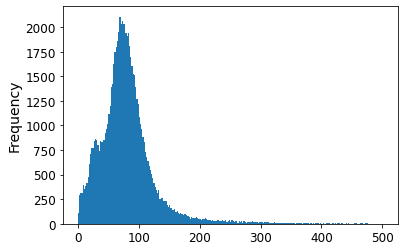

In [7]:
df['site_eui'].plot(kind='hist', bins=250, range=(0,500))

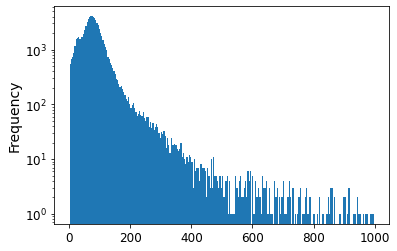

In [8]:
df['site_eui'].plot(kind='hist', bins=250, logy=True)

In [9]:
df['site_eui'].describe()

count    75757.000000
mean        82.584693
std         58.255403
min          1.001169
25%         54.528601
50%         75.293716
75%         97.277534
max        997.866120
Name: site_eui, dtype: float64

#### ID
building id => different for each row

In [10]:
df['id']

0            0
1            1
2            2
3            3
4            4
         ...  
75752    75752
75753    75753
75754    75754
75755    75755
75756    75756
Name: id, Length: 75757, dtype: int64

In [11]:
df_test['id'] # the numbering continues from the training set

0       75757
1       75758
2       75759
3       75760
4       75761
        ...  
9700    85457
9701    85458
9702    85459
9703    85460
9704    85461
Name: id, Length: 9705, dtype: int64

#### State

In [12]:
df['State_Factor'].value_counts().sort_index()

State_1      5618
State_10       15
State_11     6412
State_2      4871
State_4      4300
State_6     50840
State_8      3701
Name: State_Factor, dtype: int64

In [13]:
df.insert(loc=2, column='State_id', value = df['State_Factor'].str.split('_').str.get(1).astype(int))

In [14]:
df['State_id'].value_counts().sort_index()

1      5618
2      4871
4      4300
6     50840
8      3701
10       15
11     6412
Name: State_id, dtype: int64

In [15]:
df.drop('State_Factor', axis=1, inplace=True)

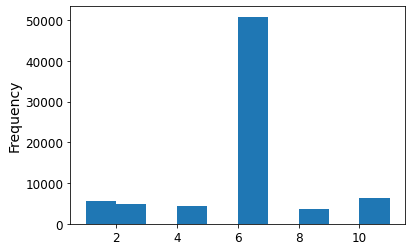

In [16]:
df['State_id'].plot(kind='hist')

In [17]:
#df_test.drop('State_id', inplace=True, axis=1)
df_test.insert(loc=2, column='State_id', value = df_test['State_Factor'].str.split('_').str.get(1).astype(int))
df_test['State_id']

0        1
1        1
2        1
3        1
4        1
        ..
9700    11
9701    11
9702    11
9703    11
9704    11
Name: State_id, Length: 9705, dtype: int64

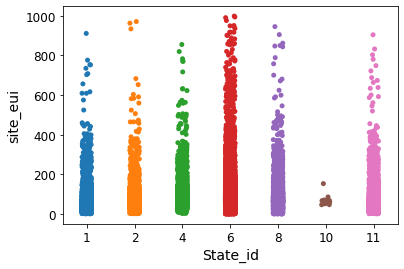

In [18]:
#sns.swarmplot(x='State_id', y='site_eui', data=df)
sns.stripplot(x='State_id', y='site_eui', data=df, jitter=True)

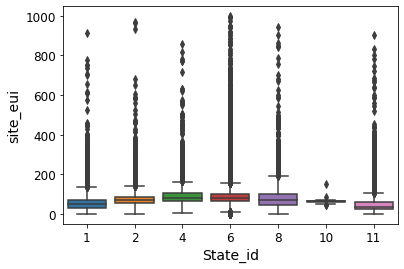

In [19]:
sns.boxplot(x='State_id', y='site_eui', data=df,)

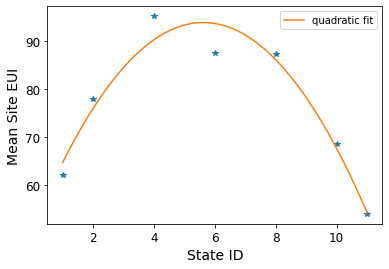

In [20]:
mean_eui_state = df.groupby('State_id')['site_eui'].mean()
mean_eui_state
plt.plot(mean_eui_state.index, mean_eui_state.values, '*')
#m,q = np.polyfit(mean_eui_state.index, mean_eui_state.values, deg=1)
xs = np.linspace(1,11,110)
#plt.plot(xs, xs*m+q, label='linear fit')
m1,m,q, = np.polyfit(mean_eui_state.index, mean_eui_state.values, deg=2)
plt.plot(xs, xs**2*m1+xs*m+q, label='quadratic fit')
plt.xlabel('State ID')
plt.ylabel('Mean Site EUI')
plt.legend()

##### Considerations
- some states are more represented than others
- there seems to be a relation between the the mean site_eui in each state and the state id, suggesting that this variable could be **relevant** to regress the site_eui
- one-hot encoding or ordinal category? as there is no clear ordering between states, we believe it makes sense to perform **one-hot encoding**

#### Year Factor

In [21]:
df['Year_Factor'].value_counts()

6    22449
5    18308
4    12946
3    10879
2     9058
1     2117
Name: Year_Factor, dtype: int64

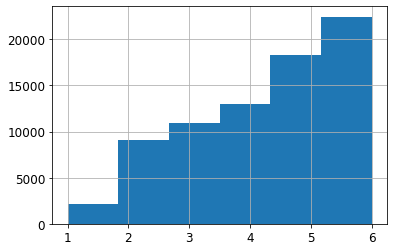

In [22]:
df['Year_Factor'].hist(bins=6)

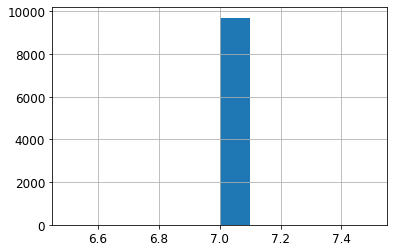

In [23]:
df_test['Year_Factor'].hist()

In [24]:
#sns.jointplot(x='Year_Factor', y='site_eui', data=df, kind='reg')

##### Considerations

- our observations are distributed unequally in the year
- we can think the year_variable as a variable that tells us about the general climatic conditions of that year (e.g. if it was particularly hot or cold we expect a higher site_eui). This information is probably redundant with a lot of the weather/climatic information
- we don't plan to do any particular transformation on this variable, of course we can min-max scale it
- the **training set** has values **ranging from 1 to 6**; the **test set** has values **only on year 7**: this suggests that the information on the site_eui of the previous years for a given type of building could be used directly as a feature to predict the year 7 site_eui.  

#### Elevation


In [25]:
df['ELEVATION'].value_counts()

42.7      18822
3.4       12004
15.2       6399
18.3       4520
25.6       4072
          ...  
413.6         1
121.6         1
1428.9        1
82.9          1
1380.7        1
Name: ELEVATION, Length: 193, dtype: int64

In [26]:
df['ELEVATION'].value_counts().shape

(193,)

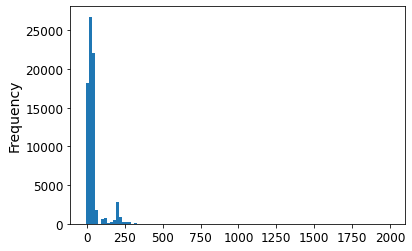

In [27]:
df['ELEVATION'].plot(kind='hist', bins=100, range=(-10,2000))

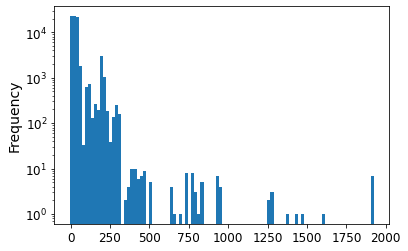

In [28]:
df['ELEVATION'].plot(kind='hist',logy=True, bins=100)

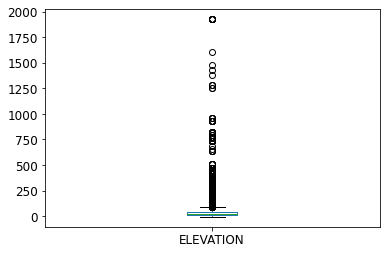

In [29]:
df['ELEVATION'].plot(kind='box')

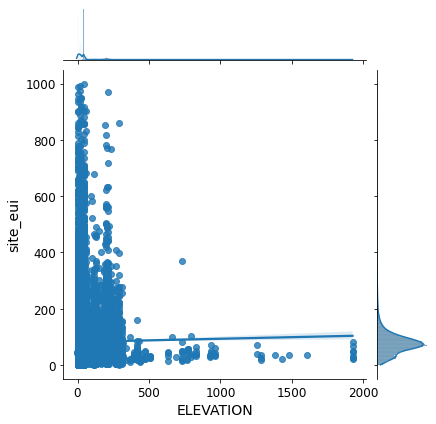

In [30]:
sns.jointplot(x='ELEVATION', y='site_eui', data=df, kind='reg')

In [31]:
#sns.lmplot(x='ELEVATION', y='site_eui', data=df, col='State_id', col_wrap=3, height=5)

/Users/mratti/opt/miniconda3/envs/wids/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


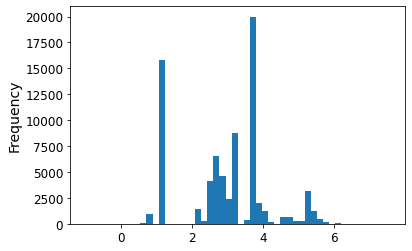

In [32]:
#df['ELEVATION'].plot(kind='hist', bins=100, range=(0,500))
df['log_ELEVATION'] = np.log(df['ELEVATION'])
df['log_ELEVATION'].fillna(-1, inplace=True) # negative elevation set to 0
df['log_ELEVATION'].plot(kind='hist', bins=50)
#df['log_ELEVATION'].isnull().value_counts()

For some reason, it seems that the elevation is discretised and has a rather strange distribution

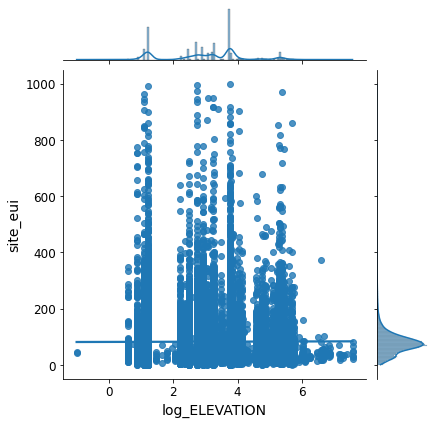

In [33]:
sns.jointplot(x='log_ELEVATION', y='site_eui', data=df, kind='reg')

In [34]:
#sns.lmplot(x='log_ELEVATION', y='site_eui', data=df, col='State_id', col_wrap=3, height=5)

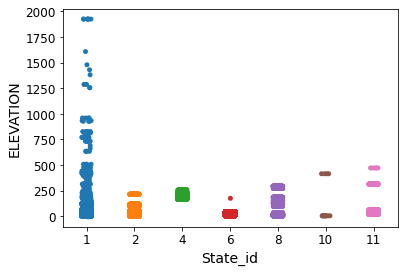

In [35]:
#sns.boxplot(x='State_id', y='ELEVATION', data=df,)
sns.stripplot(x='State_id', y='ELEVATION', data=df,)
#sns.violinplot(x='State_id', y='ELEVATION', data=df,)
###sns.swarmplot(x='State_id', y='ELEVATION', data=df,) does not work for some reason

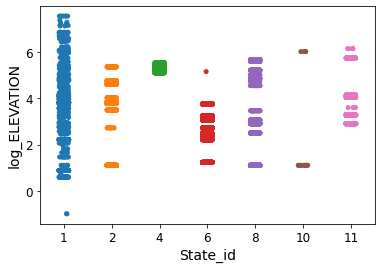

In [36]:
sns.stripplot(x='State_id', y='log_ELEVATION', data=df,)

In [37]:
df['ELEVATION_cat'] = pd.cut(x=df['ELEVATION'], bins=[-np.inf,40,100,150,250,400,1000,np.inf], labels=False)

In [38]:
df[['ELEVATION', 'ELEVATION_cat']].tail(5)

,ELEVATION,ELEVATION_cat
75752,36.6,0
75753,36.6,0
75754,36.6,0
75755,36.6,0
75756,36.6,0


In [39]:
df.corr().loc[['ELEVATION', 'ELEVATION_cat'],'site_eui'] 

ELEVATION        0.011798
ELEVATION_cat    0.028462
Name: site_eui, dtype: float64

In [40]:
df.corr().loc[['ELEVATION', 'ELEVATION_cat'],['avg_temp','january_avg_temp', 'july_avg_temp', 'september_avg_temp']] 

,avg_temp,january_avg_temp,july_avg_temp,september_avg_temp
ELEVATION,-0.326495,-0.233452,-0.187750,-0.014956
ELEVATION_cat,-0.349296,-0.291375,-0.183661,0.012934


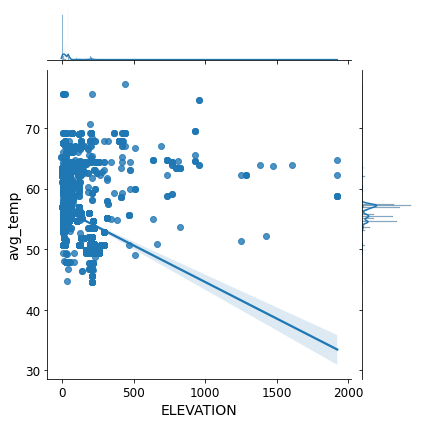

In [41]:
sns.jointplot(x='ELEVATION', y='avg_temp', data=df, kind='reg')

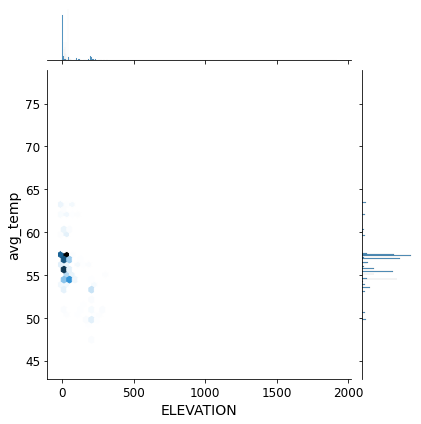

In [42]:
sns.jointplot(x='ELEVATION', y='avg_temp', data=df, kind='hex')

##### Considerations
- there seems to be a **postive correlation** between **ELEVATION** and **site_eui** (which we recognise as making sense, as for higher elevation, you need more heating); this correlation is not clearly visible when categorising by State_id
- the log transformation for the elevation makes the distribution more compact (less outliers, smaller range); but it seems to lose the correlation with the site_eui; therefore, it is currently not recommended.
- we cut the ELEVATION distribution in **categories**, which make sense from a **climate** point of view (assumption is that the elevetaion is expressed in meters): positive linear correlation with the site_eui is increased after categorisation
- the State_id and the ELEVATION do not seem to have a clear relation and the elevation distribution in each state looks quite different 
- could the ELEVATION have information about the city a given building belongs to?

#### Building class

In [43]:
df['building_class'].value_counts()

Residential    43558
Commercial     32199
Name: building_class, dtype: int64

In [44]:
df['isResidential'] = df['building_class'] == 'Residential'
df['isResidential'] = df['isResidential'].astype(int)

In [45]:
df['isResidential'].value_counts()

1    43558
0    32199
Name: isResidential, dtype: int64

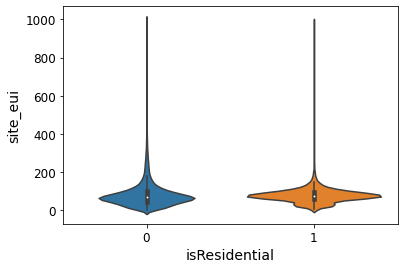

In [46]:
sns.violinplot(x='isResidential', y='site_eui', data=df)

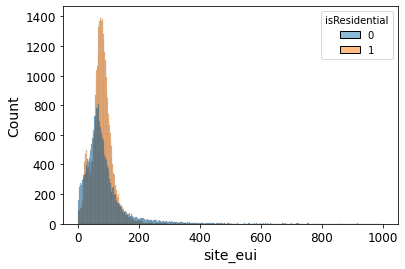

In [47]:
sns.histplot(data=df, x='site_eui', hue="isResidential", stat='count')

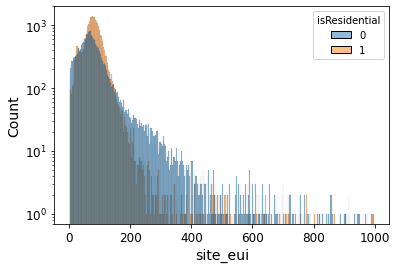

In [48]:
sns.histplot(data=df, x='site_eui', hue="isResidential", stat='count', log_scale=(False,True))

In [49]:
df.groupby('isResidential')['site_eui'].mean()

isResidential
0    85.755239
1    80.240957
Name: site_eui, dtype: float64

In [50]:
df.groupby('isResidential')['site_eui'].std()

isResidential
0    75.314131
1    41.188882
Name: site_eui, dtype: float64

In [51]:
df.groupby('isResidential')['site_eui'].median()

isResidential
0    69.667075
1    78.010999
Name: site_eui, dtype: float64

##### Considerations
- there seems to be a significant difference in the site_eui distribution between residential and commercial buildings
  - commercial buildings having a larger tail towards high values, a higher mean, a higher variance
  - residential buildings have a higher median though

- It would be interesting to understand where the structure at low values of site_eui comes from in residential buildings; maybe it is related to the facility type? (it seems so: looking at facility type, for 2to4, 5plus we have lower values, for multifamily we have higher values of site_eui)

- we plan to trasnform this variable into categorical, one category only. 

#### Facility type

In [52]:
print(len(df['facility_type'].value_counts().sort_index()))
df['facility_type'].value_counts().sort_index()

60


2to4_Unit_Building                            1893
5plus_Unit_Building                           1273
Commercial_Other                              1744
Commercial_Unknown                              95
Data_Center                                     27
Education_College_or_university               1056
Education_Other_classroom                     3860
Education_Preschool_or_daycare                 108
Education_Uncategorized                        709
Food_Sales                                      70
Food_Service_Other                              17
Food_Service_Restaurant_or_cafeteria            64
Food_Service_Uncategorized                      18
Grocery_store_or_food_market                   448
Health_Care_Inpatient                          409
Health_Care_Outpatient_Clinic                   56
Health_Care_Outpatient_Uncategorized            36
Health_Care_Uncategorized                       51
Industrial                                     384
Laboratory                     

In [53]:
df.groupby('facility_type')['isResidential'].sum()

facility_type
2to4_Unit_Building                            1893
5plus_Unit_Building                           1273
Commercial_Other                                 0
Commercial_Unknown                               0
Data_Center                                      0
Education_College_or_university                  0
Education_Other_classroom                        0
Education_Preschool_or_daycare                   0
Education_Uncategorized                          0
Food_Sales                                       0
Food_Service_Other                               0
Food_Service_Restaurant_or_cafeteria             0
Food_Service_Uncategorized                       0
Grocery_store_or_food_market                     0
Health_Care_Inpatient                            0
Health_Care_Outpatient_Clinic                    0
Health_Care_Outpatient_Uncategorized             0
Health_Care_Uncategorized                        0
Industrial                                       0
Laboratory       

Only facility types that belong to residential are:
```
2to4_Unit_Building                            1541
5plus_Unit_Building                           1031
Mixed_Use_Commercial_and_Residential           540
Mixed_Use_Predominantly_Commercial             208
Mixed_Use_Predominantly_Residential              8
Multifamily_Uncategorized                    31484
```
the 'mixed' are in fact categorised as residential

In order to reduce the number of categories, we can introduce a super categorisation, given by the first string in the facility type.

In [54]:
df['facility_type_super'] = df['facility_type'].str.split('_').str.get(0)
df['facility_type_super'].value_counts()

Multifamily    39455
Office         13150
Education       5733
Warehouse       2879
Lodging         2847
2to4            1893
Commercial      1839
Retail          1437
5plus           1273
Public           990
Mixed            937
Nursing          772
Health           552
Grocery          448
Religious        399
Industrial       384
Parking          251
Service          215
Food             169
Laboratory       107
Data              27
Name: facility_type_super, dtype: int64

In [55]:
df.groupby('facility_type_super')['site_eui'].agg(['mean','std','median', 'max', 'min']).sort_values('mean')

,mean,std,median,max,min
facility_type_super,,,,,
2to4,31.876915,15.384904,27.721010,149.488903,5.078905
5plus,36.737785,17.063089,32.113695,159.722183,10.314208
Warehouse,37.190052,45.366058,26.306003,813.290082,1.001169
Religious,44.560675,31.826133,36.001366,178.147259,2.252498
Parking,67.351241,147.998741,14.240125,975.452321,1.198625
Education,73.622604,54.513264,65.719945,989.887978,1.795082
Office,78.599046,51.379891,69.609145,970.388586,1.002998
Retail,83.134903,70.129146,68.312842,854.660523,1.400000
Multifamily,83.878522,38.620974,80.389641,993.428259,1.003281


In [56]:
cats = df.groupby('facility_type_super')['site_eui'].agg(['mean','std','median', 'max', 'min']).sort_values('mean').index.to_list()

In [57]:
len(cats)

21

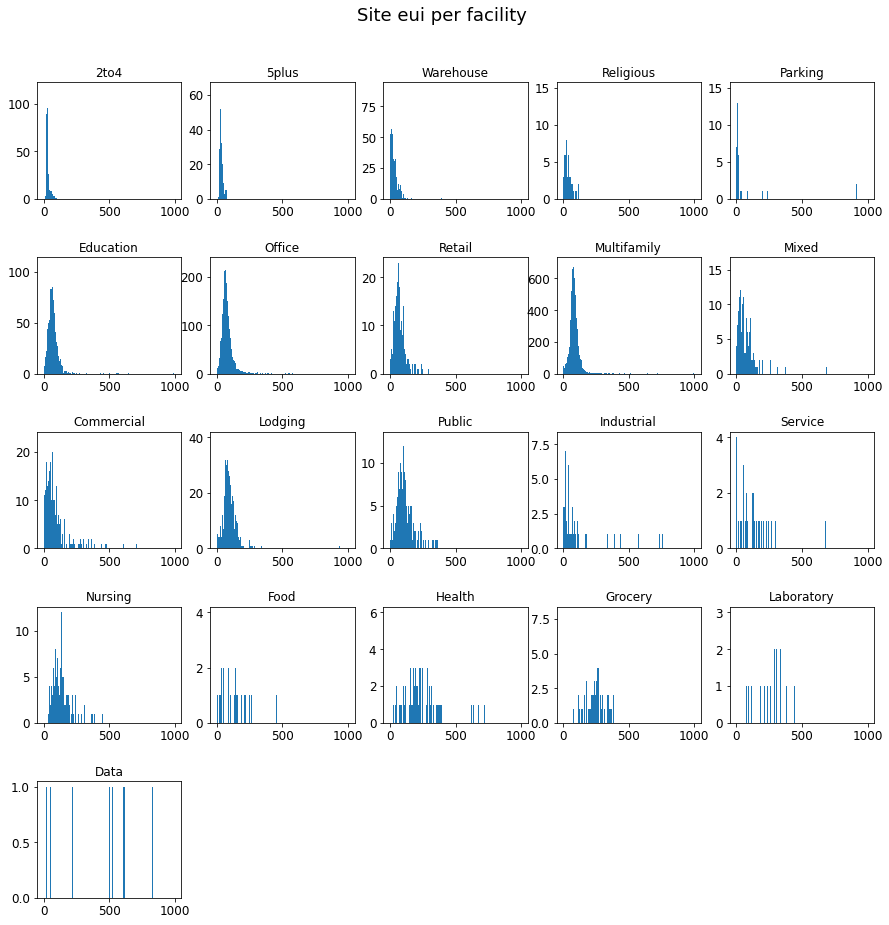

In [58]:
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Site eui per facility", fontsize=18, y=0.95)

for n, cat in enumerate(cats):
    # add a new subplot iteratively
    ax = plt.subplot(5, 5, n + 1)

    ax.hist(df[df['facility_type_super'] == cat]['site_eui'], bins=1000, range=(0,1000))

    # chart formatting
    ax.set_title(cat)
    #ax.get_legend().remove()
    #ax.set_xlabel("site eui")


In [55]:
#sns.histplot(data=df, x='site_eui', hue="facility_type_super", stat='probability', common_norm=True)

##### Considerations

- different facility groups have different site eui (mean and distribution differ), as well as different number of events
- we expect this categorisation to be very important to determine the site_eui of a building, at the point that one could think of tranining different models for each category
- we should try to see if it is better to reduce the number of categories to 21 (super categories) or keep the initial number of categories (60). In all cases, a one-hot encoding is appropriate, since we don't have a defined ordering in the categories. 


#### Floor area

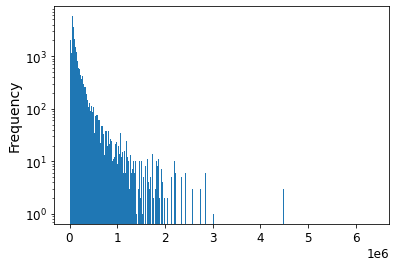

In [59]:
df['floor_area'].plot(kind='hist',logy=True, bins=1000)

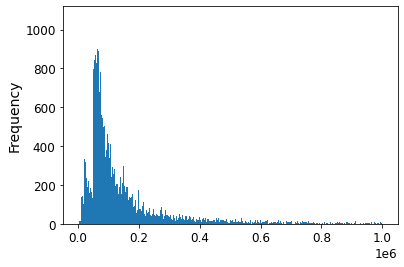

In [60]:
df['floor_area'].plot(kind='hist',bins=1000, range=(1,1e06))

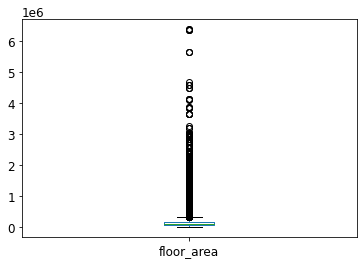

In [61]:
df['floor_area'].plot(kind='box')

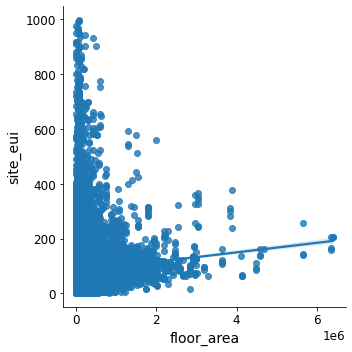

In [62]:
sns.lmplot(x='floor_area', y='site_eui', data=df)

In [63]:
#sns.lmplot(x='floor_area', y='site_eui', data=df, col='isResidential')

##### Considerations

- The floor area has a very large range and will need scaling; given the high presence of outliers, standardisation is recommended
- there is a positive correlation between floor area and site_eui (which is maintained separately in residential and commercial buildings); so this variable is useful 

#### year built

In [64]:
df['year_built'].value_counts().sort_index()

0.0         6
1600.0      6
1649.0      4
1732.0      1
1756.0      4
         ... 
2011.0    279
2012.0    353
2013.0    398
2014.0    269
2015.0    111
Name: year_built, Length: 180, dtype: int64

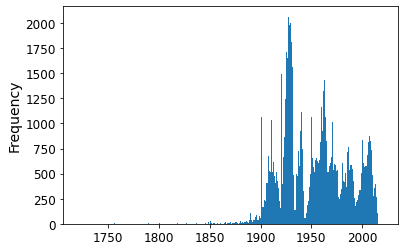

In [65]:
df['year_built'].plot(kind='hist', bins=300, range=(1720,2020))

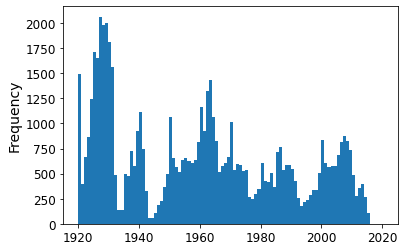

In [66]:
df['year_built'].plot(kind='hist', bins=100, range=(1920,2020))

Percentage of null values = 2.4 %
We could try to impute the year of construction based on the facility_type - take e.g. the average or median per facility type, state, and floor_area category?

In [67]:
df.groupby(['facility_type_super'])['year_built'].agg(['median', 'count'])

,median,count
facility_type_super,,
2to4,1978.0,1892
5plus,1997.0,1272
Commercial,1949.0,1760
Data,1962.0,27
Education,1954.0,5040
Food,1971.0,166
Grocery,1986.5,436
Health,1957.0,525
Industrial,1948.0,380


In [68]:
df.groupby('facility_type')['year_built'].agg(['median', 'count'])

,median,count
facility_type,,
2to4_Unit_Building,1978.0,1892
5plus_Unit_Building,1997.0,1272
Commercial_Other,1948.0,1680
Commercial_Unknown,1964.0,80
Data_Center,1962.0,27
Education_College_or_university,1962.0,1030
Education_Other_classroom,1950.0,3823
Education_Preschool_or_daycare,1971.5,108
Education_Uncategorized,1950.0,79


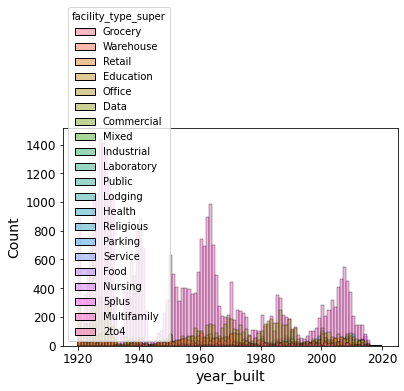

In [69]:
sns.histplot(data=df, x='year_built', hue='facility_type_super', bins=100, binrange=(1920,2020) )

In [129]:
df.corr().loc['year_built', ['floor_area', 'State_id']]

floor_area    0.098791
State_id      0.081287
Name: year_built, dtype: float64

In [70]:
# iterative imputation to fill missing values: start from max amount of information available and 
# reduce information at each step.
# Order the features for imputation such that the last feature to be dropped is expected to be the most useful 
# 
# - State_id, floor_area, building_class, facility_type,

# first replace infinite values with nans
print ('Before inf substitution, number of NaNs: {}'.format(df.year_built.isna().sum()))
df.replace(to_replace=[-np.inf,np.inf], value=np.nan)
print ('Before imputation, number of NaNs: {}'.format(df.year_built.isna().sum()))

year_imputation_list = ['State_id','floor_area','building_class', 'facility_type']
for istart,feat in enumerate(year_imputation_list):
  print(year_imputation_list[istart:])
  df['year_imputed'] = df.groupby(year_imputation_list[istart:])['year_built'].transform('median')
  df['year_built'] = df['year_built'].fillna(df['year_imputed'] )
  print ('After imputation step {}, number of NaNs: {}'.format(istart+1, df.year_built.isna().sum()))

  
# couldn't we do this based on both the training set and the test set together?
# this way we would do the imputation on the maximal amount of information available... 

Before inf substitution, number of NaNs: 1837
Before imputation, number of NaNs: 1837
['State_id', 'floor_area', 'building_class', 'facility_type']
After imputation step 1, number of NaNs: 1690
['floor_area', 'building_class', 'facility_type']
After imputation step 2, number of NaNs: 1667
['building_class', 'facility_type']
After imputation step 3, number of NaNs: 0
['facility_type']
After imputation step 4, number of NaNs: 0


In [71]:
#mapping_year_on_facility_type = df.groupby('facility_type')['year_built'].median().to_dict()
#mapping_year_on_facility_type

In [72]:
#mask1 = df['year_built'].isna() 
#mask2 = df['year_built'] == 0
#mask = (mask1 | mask2) # one has to be extremely careful with the syntax of masking...
##mask.index.to_list()
#mask.sum()

In [73]:
##df.apply()
#df.loc[mask,'year_built'] = df.loc[mask,'facility_type'].map(mapping_year_on_facility_type)
##df.loc[indexes_nans,['year_built','facility_type']] # seems to have worked

In [74]:
#df['year_built'].value_counts().sort_index(ascending=True)

now that we have filled the missing values we can check the correlation with the site_eui

In [75]:
#df.loc[mask]
df['year_built'].isna().sum()

0

In [76]:
#sns.lmplot(x='year_built', y='site_eui', data=df[df['year_built']>1800])

##### Considerations

- year_built is a multi-modal distribution with some outliers at the beginning
- there are 2.5% missing values. 
  - A possible strategy is to impute the year of construction based on the median per facility type. In fact we observe that some building types were constructed much more often in some periods of time than others. This is a better solution than just picking up the median independenently on everything. 
  - a **more powerful strategy** consists in performing the **imputation iteratively** with multiple features for the grouping, reduced by one feature at each step
  - couldn't we do the imputation based on **both** the **training set** and the **test set** together? 


#### Energy Star rating
energy_star_rating         39283 non-null  float64

35% of the values are missing... might be hard to impute them...

In [77]:
df['energy_star_rating'].value_counts().sort_index(ascending=True) # the higher the better i think

0.0         1
1.0       985
2.0       361
3.0       311
4.0       306
         ... 
96.0      634
97.0      633
98.0      651
99.0      709
100.0    1946
Name: energy_star_rating, Length: 101, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3c29f4460>]],
      dtype=object)

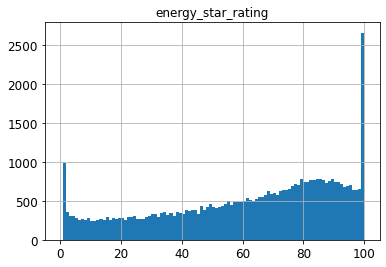

In [78]:
df.hist('energy_star_rating', bins=100) 

The value seem capped... what can we do about it?

In [79]:
df['energy_star_rating'].isna().sum()

26709

In [80]:
(~df['energy_star_rating'].isna()).sum()

49048

In [81]:
#df['year_built'].plot(kind='hist', bins=80, range=(1940,2020))
df['year_built_cat'] = pd.cut(df['year_built'], bins=[-np.inf,1850,1899,1919,1933,1945,1955,1965,1975,1985,1995,2005,np.inf], labels=False)

In [82]:
df_imputation_rating = df.groupby(['year_built_cat', 'facility_type_super'])['energy_star_rating'].median().unstack().fillna(method='bfill').fillna(method='ffill')
dic_imputation_rating = df_imputation_rating.to_dict()

#dic_imputation_rating
df_imputation_rating.head()

facility_type_super,2to4,5plus,Commercial,Data,Education,Food,Grocery,Health,Industrial,Laboratory,...,Mixed,Multifamily,Nursing,Office,Parking,Public,Religious,Retail,Service,Warehouse
year_built_cat,,,,,,,,,,,,,,,,,,,,,
0,81.0,79.0,76.0,16.5,81.5,92.5,32.0,37.0,97.5,1.0,...,79.0,41.0,11.0,82.0,96.0,65.0,95.0,82.0,31.0,88.0
1,81.0,79.0,76.0,16.5,67.0,92.5,32.0,52.0,97.5,1.0,...,79.0,48.0,33.5,78.0,96.0,65.0,95.0,82.0,31.0,84.0
2,81.0,79.0,80.0,16.5,67.0,92.5,32.0,72.0,97.5,1.0,...,79.0,61.5,65.0,79.0,96.0,16.0,73.0,63.5,31.0,73.0
3,77.0,85.0,81.5,16.5,69.0,4.0,26.5,69.5,63.0,1.0,...,86.0,64.0,22.0,79.0,96.0,40.5,67.0,71.5,31.0,75.5
4,88.0,99.5,96.0,16.5,71.0,4.0,26.5,86.0,96.5,1.0,...,75.0,67.0,82.5,77.0,96.0,70.0,94.0,78.5,25.0,61.5


In [83]:
def func_imputation_rating(row):
  facility_type_super = row[0]
  year_built_cat = row[1]
  return dic_imputation_rating[facility_type_super][year_built_cat]

df['energy_star_rating_imp'] = df['energy_star_rating'].copy()

mask = df['energy_star_rating_imp'].isna()
df.loc[mask,'energy_star_rating_imp'] = df[['facility_type_super','year_built_cat']].apply(func_imputation_rating, axis=1)

df['energy_star_rating_imp'].isna().sum()


0

In [84]:
df['energy_star_rating_na0'] = df['energy_star_rating'].copy()
df['energy_star_rating_na0'].fillna(0, inplace=True)

After median imputation

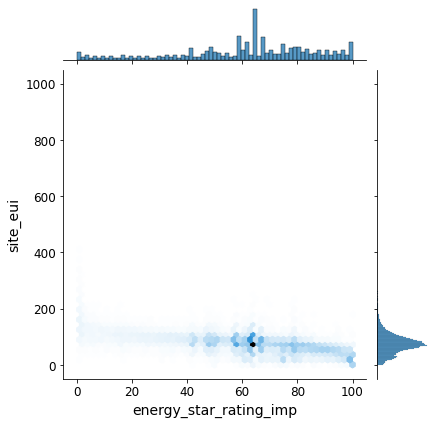

In [85]:
sns.jointplot(x='energy_star_rating_imp', y='site_eui', data=df, kind='hex')

Filling NaNs with 0

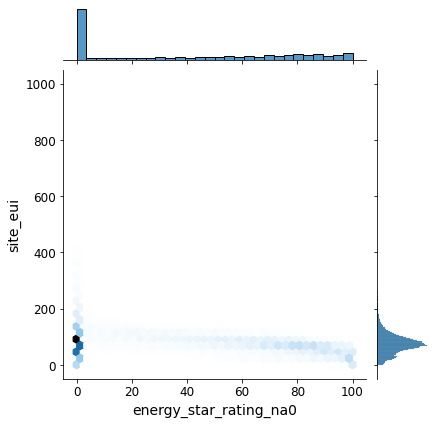

In [86]:
sns.jointplot(x='energy_star_rating_na0', y='site_eui', data=df, kind='hex')

Before imputation

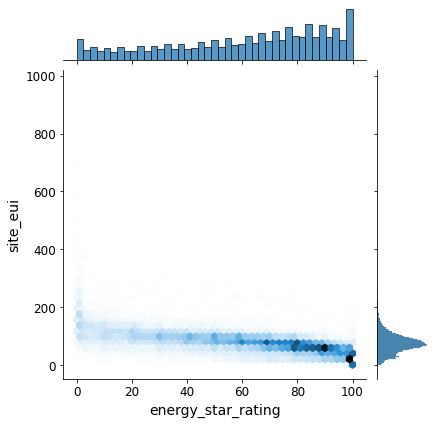

In [87]:
sns.jointplot(x='energy_star_rating', y='site_eui', data=df, kind='hex')

In [88]:
#sns.lmplot(x='energy_star_rating', y='site_eui', data=df)

In [89]:
df.corr().loc['site_eui', ['energy_star_rating','energy_star_rating_na0','energy_star_rating_imp']]

energy_star_rating       -0.511012
energy_star_rating_na0   -0.265351
energy_star_rating_imp   -0.389231
Name: site_eui, dtype: float64

##### Considerations

- Energy star rating approximately ranges between 0 and 100. It would be nice to know why the value are capped
- 35% of the events had missing values and the value was imputed by the median calculated over groups based on the year of construction (in categories) and based on the type of facility
- there is a negative linear correlation between energy_star_rating and the site_eui:
  - the correlation is 50% (strong) when considering only events with a valid value of the energy star rating
  - the correlation is reduced to 38%, when imputing with the above mentioned method, but it is still better than filling the missing numbers with 0 (correlation reduced to 26%)

### Correlation so far

In [90]:
codes, uniques = df['facility_type'].factorize()
codes_super, uniques_super = df['facility_type_super'].factorize()

In [91]:
df.loc[:,'facility_type'] = codes
df.loc[:,'facility_type_super'] = codes_super

In [92]:
df['facility_type_super']

0         0
1         1
2         2
3         3
4         1
         ..
75752     4
75753    18
75754     6
75755     6
75756    20
Name: facility_type_super, Length: 75757, dtype: int64

In [93]:
#abs(df.corr()['site_eui']).sort_values(ascending=False).head(50)
variables = ['Year_Factor','State_id', 'ELEVATION', 'ELEVATION_cat','isResidential', 'floor_area','facility_type_super', 'facility_type', 'year_built', 'year_built_cat', 'Year_Factor','energy_star_rating', 'energy_star_rating_imp']
abs(df.corr()).loc[variables,'site_eui'] 
                       

Year_Factor               0.045179
State_id                  0.031843
ELEVATION                 0.011798
ELEVATION_cat             0.028462
isResidential             0.046794
floor_area                0.073967
facility_type_super       0.015767
facility_type             0.015579
year_built                0.017559
year_built_cat            0.017482
Year_Factor               0.045179
energy_star_rating        0.511012
energy_star_rating_imp    0.389231
Name: site_eui, dtype: float64

### Individual features - WEATHER

#### Monthly temperatures

In [94]:
months = [x.split('_')[0] for x in df.columns.to_list() if 'temp' in x]
months = list(dict.fromkeys(months))[:-1]
months

['january',
 'february',
 'march',
 'april',
 'may',
 'june',
 'july',
 'august',
 'september',
 'october',
 'november',
 'december']

In [95]:
cats = [(x+'_avg_temp',x+'_min_temp',x+'_max_temp') for x in months ]
cats
#all_cats

[('january_avg_temp', 'january_min_temp', 'january_max_temp'),
 ('february_avg_temp', 'february_min_temp', 'february_max_temp'),
 ('march_avg_temp', 'march_min_temp', 'march_max_temp'),
 ('april_avg_temp', 'april_min_temp', 'april_max_temp'),
 ('may_avg_temp', 'may_min_temp', 'may_max_temp'),
 ('june_avg_temp', 'june_min_temp', 'june_max_temp'),
 ('july_avg_temp', 'july_min_temp', 'july_max_temp'),
 ('august_avg_temp', 'august_min_temp', 'august_max_temp'),
 ('september_avg_temp', 'september_min_temp', 'september_max_temp'),
 ('october_avg_temp', 'october_min_temp', 'october_max_temp'),
 ('november_avg_temp', 'november_min_temp', 'november_max_temp'),
 ('december_avg_temp', 'december_min_temp', 'december_max_temp')]

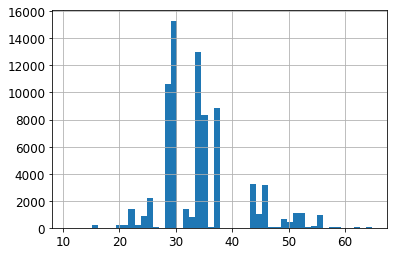

In [96]:
df['january_avg_temp'].hist(bins=50)

In [97]:
to_display = [item for sublist in cats for item in sublist]
df[to_display].describe()

,january_avg_temp,january_min_temp,january_max_temp,february_avg_temp,february_min_temp,february_max_temp,march_avg_temp,march_min_temp,march_max_temp,april_avg_temp,...,september_max_temp,october_avg_temp,october_min_temp,october_max_temp,november_avg_temp,november_min_temp,november_max_temp,december_avg_temp,december_min_temp,december_max_temp
count,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000
mean,34.310468,11.432343,59.054952,35.526837,11.720567,58.486278,44.469292,21.606281,70.897831,53.784863,...,92.171139,58.727038,38.210911,81.135671,48.123133,28.630397,71.202397,41.625569,22.736777,64.496852
std,6.996108,9.381027,5.355458,8.866697,12.577272,8.414611,6.657142,10.004303,7.680982,2.500473,...,5.011708,2.641300,5.093899,5.579513,4.094207,7.153244,4.373374,5.869386,9.014047,6.054104
min,10.806452,-19.000000,42.000000,13.250000,-13.000000,38.000000,25.854839,-9.000000,53.000000,40.280000,...,64.000000,44.693548,18.000000,59.000000,30.766667,4.000000,53.000000,23.790323,-16.000000,42.000000
25%,29.827586,6.000000,56.000000,31.625000,2.000000,55.000000,38.096774,13.000000,62.000000,52.333333,...,91.000000,58.048387,35.000000,78.000000,45.250000,23.000000,69.000000,38.532258,17.000000,60.000000
50%,34.451613,11.000000,59.000000,34.107143,9.000000,61.000000,44.516129,25.000000,71.000000,53.333333,...,92.000000,58.758065,38.000000,80.000000,47.116667,31.000000,72.000000,40.516129,24.000000,65.000000
75%,37.322581,13.000000,62.000000,40.879310,20.000000,62.000000,49.354839,27.000000,78.000000,54.766667,...,96.000000,59.629032,40.000000,85.000000,51.339286,34.000000,74.000000,43.435484,28.000000,71.000000
max,64.758065,49.000000,91.000000,65.107143,48.000000,89.000000,69.758065,52.000000,95.000000,74.500000,...,111.000000,80.741935,61.000000,108.000000,67.416667,52.000000,96.000000,61.790323,44.000000,86.000000


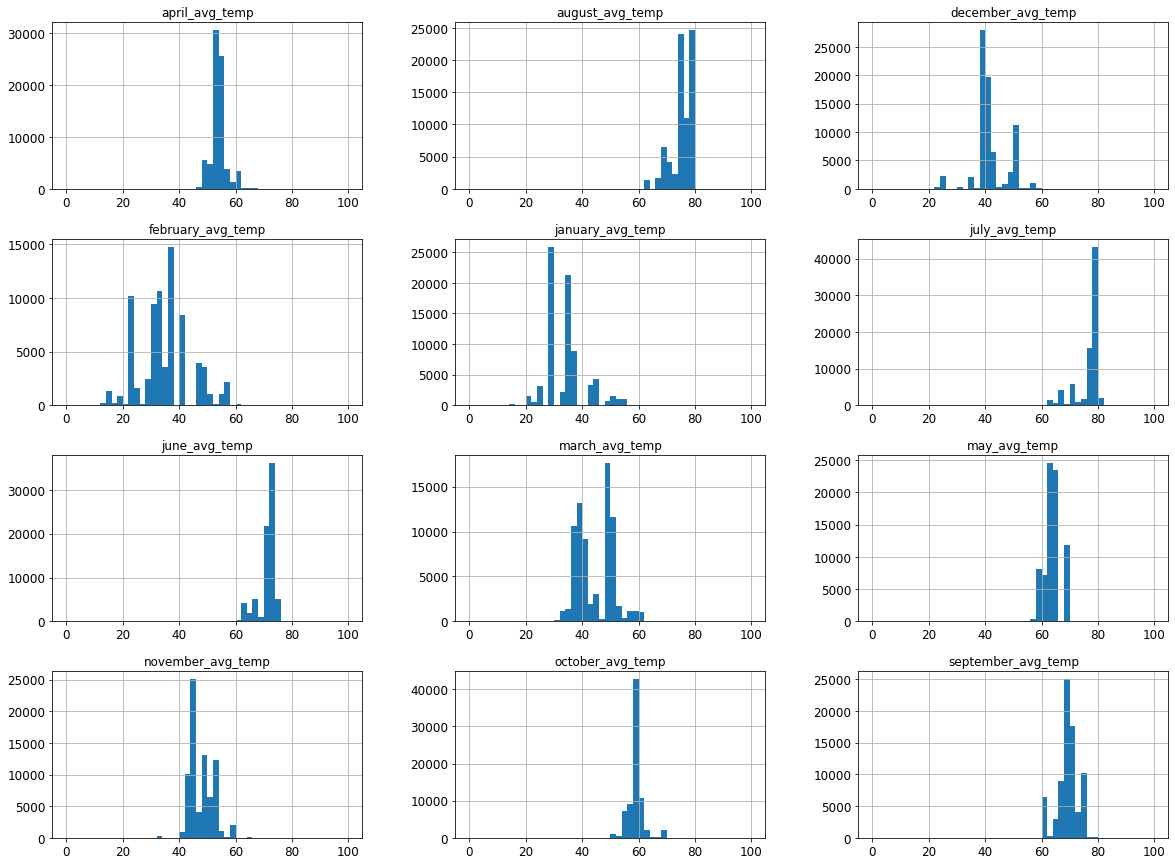

In [98]:
to_display = [item for sublist in cats for item in sublist]
avg_cats = [cat for cat in to_display if 'avg' in cat]
df.loc[:,avg_cats].hist(bins=50, range=(0,100), figsize=(20,15))
plt.show()


Looking at joint plot with site_eui is not particularly instructive...

In [99]:
#fig,ax = plt.subplots(12,3,figsize=(12,40))
#
#for n, cat in enumerate(cats):
#
#    sns.jointplot(x=cat[0],y='site_eui',data=df, kind='hist', ax=ax[n][0])
#    sns.jointplot(x=cat[1],y='site_eui',data=df, kind='hist', ax=ax[n][1])
#    sns.jointplot(x=cat[2],y='site_eui',data=df, kind='hist', ax=ax[n][2])
#

Better to look directly at the correlation matrix

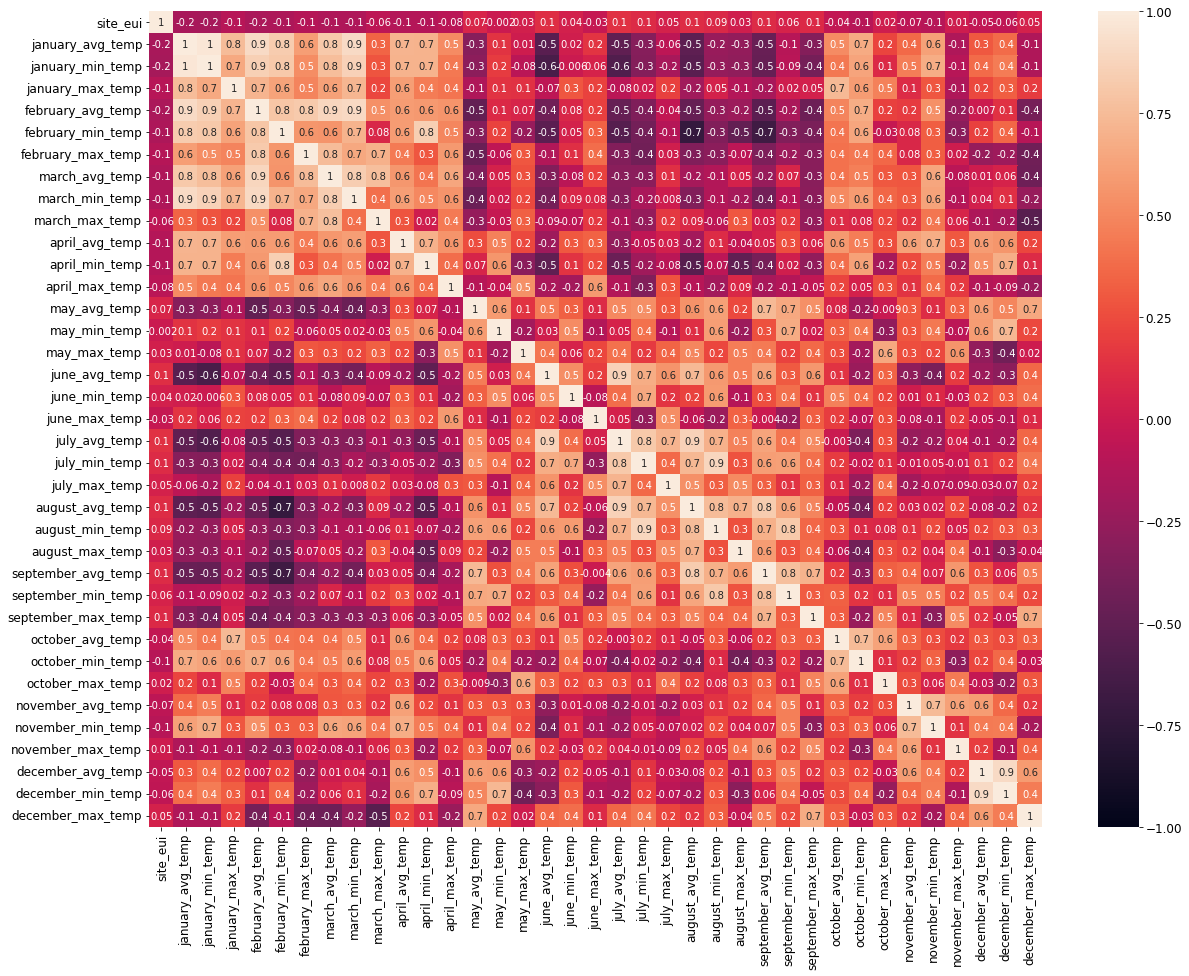

In [100]:
to_display = [item for sublist in cats for item in sublist]
to_display.insert(0,'site_eui')

corr = df.corr().loc[to_display,to_display]
#corr
#print(type(corr_matrix))
plt.figure(figsize=(20,15))
heatmap = sns.heatmap(corr, annot=True, fmt='.1g', annot_kws={"fontsize":10}, vmin=-1, vmax=1, 
                      #xticklabels=list(df_prepared.columns), yticklabels=list(df_prepared.columns)
                     )
#heatmap.get_figure()


In [101]:
avg_cats = [cat for cat in to_display if 'avg' in cat]
corr.loc[avg_cats,'site_eui']


january_avg_temp     -0.167982
february_avg_temp    -0.154071
march_avg_temp       -0.135303
april_avg_temp       -0.113008
may_avg_temp          0.072271
june_avg_temp         0.122019
july_avg_temp         0.133856
august_avg_temp       0.113786
september_avg_temp    0.108853
october_avg_temp     -0.040162
november_avg_temp    -0.069882
december_avg_temp    -0.050328
Name: site_eui, dtype: float64

In [102]:
min_cats = [cat for cat in to_display if 'min' in cat]
corr.loc[min_cats,'site_eui']


january_min_temp     -0.179190
february_min_temp    -0.147348
march_min_temp       -0.134110
april_min_temp       -0.111528
may_min_temp         -0.002043
june_min_temp         0.042291
july_min_temp         0.108092
august_min_temp       0.091616
september_min_temp    0.060203
october_min_temp     -0.095334
november_min_temp    -0.100349
december_min_temp    -0.058888
Name: site_eui, dtype: float64

In [103]:
max_cats = [cat for cat in to_display if 'max' in cat]
corr.loc[max_cats,'site_eui']

january_max_temp     -0.097070
february_max_temp    -0.106693
march_max_temp       -0.064302
april_max_temp       -0.078969
may_max_temp          0.031679
june_max_temp        -0.029233
july_max_temp         0.047884
august_max_temp       0.028359
september_max_temp    0.098326
october_max_temp      0.021272
november_max_temp     0.012002
december_max_temp     0.054068
Name: site_eui, dtype: float64

##### Considerations

- the **average temperature** in the month experienced by each building is **positively correlated** with its site_eui for **warm months** and **negatively** correlated for **cold months**, as expected
- the correlation is **confirmed** with the **minimum temperature** recorded in the month
- for the **max temperature**, the trend is **not exactly the same**: 
  - for example in october, november and december a higher max temperature is associated with a higher energy consumption (does it mean that air conditioning is used in case a high temperature is recorded?) 
  - in june, a higher max temperature is associated with a lower energy consumption 


  ==> are we sure that we gain performance from using the minimal and maximal temperatures? this could be checked


- there are no missing values in those columns
- the distributions have one or two modes, do not present terrible outliers => min-max scaling
- I'm not sure if min-max scaling is a good idea: wouldn't it be interesting for the algorithm to know the absolute differences in temperatures for different months?
   - a BDT is insensitive on the scale and does not combine different features on itw own, so the quick answer is no for BDTs
   - for a linear regression,  we know from ML theory that it does not perform well when the scales of the features are very different between one another
   - one could add differences in temperatures as features, and see if they are correlated with the energy intensity

#### Average temperature

In [104]:
df['avg_temp'].describe()

count    75757.000000
mean        56.176705
std          2.241940
min         44.512329
25%         55.147541
50%         56.835616
75%         57.215847
max         77.245205
Name: avg_temp, dtype: float64

In [105]:
df['avg_temp'].isna().sum()

0

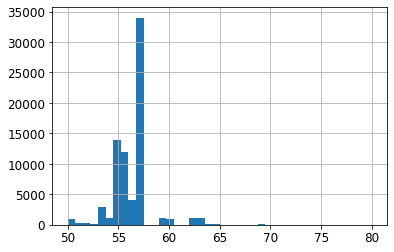

In [106]:
#df['avg_temp'].hist(bins=40, range=(40,80))
df['avg_temp'].hist(bins=40, range=(50,80))
# [-np.inf,52,55,57,58,65,np.inf]

In [107]:
df.corr().loc['site_eui','avg_temp']

-0.0892007337098815

##### Considerations

- outliers are OK in my mind, they are not terrible, min-max scaling should work
- no missing values
- mild correlation with the target, useful

#### Days with temp below/above a threshold



(C)(NUM) `days_below_30F`: total number of days below 30 degrees Fahrenheit at the location of the building (-1° C)

(C)(NUM) `days_below_20F`: total number of days below 20 degrees Fahrenheit at the location of the building (-7)

(C)(NUM) `days_below_10F`: total number of days below 10 degrees Fahrenheit at the location of the building (-12)

(C)(NUM) `days_below_0F`: total number of days below 0 degrees Fahrenheit at the location of the building (-17)

(C)(NUM) `days_above_80F`: total number of days above 80 degrees Fahrenheit at the location of the building (+27)

(C)(NUM) `days_above_90F`: total number of days above 90 degrees Fahrenheit at the location of the building (+32)

(C)(NUM) `days_above_100F`: total number of days above 100 degrees Fahrenheit at the location of the building (+38)

(C)(NUM) `days_above_110F`: total number of days above 110 degrees Fahrenheit at the location of the building (+43)

In [108]:
days_cats = ['days_below_30F','days_below_20F','days_below_10F','days_below_0F','days_above_80F','days_above_90F','days_above_100F','days_above_110F']
days_cats

['days_below_30F',
 'days_below_20F',
 'days_below_10F',
 'days_below_0F',
 'days_above_80F',
 'days_above_90F',
 'days_above_100F',
 'days_above_110F']

In [109]:
df['days_cold_or_warm'] = df['days_below_30F'] + df['days_above_80F']

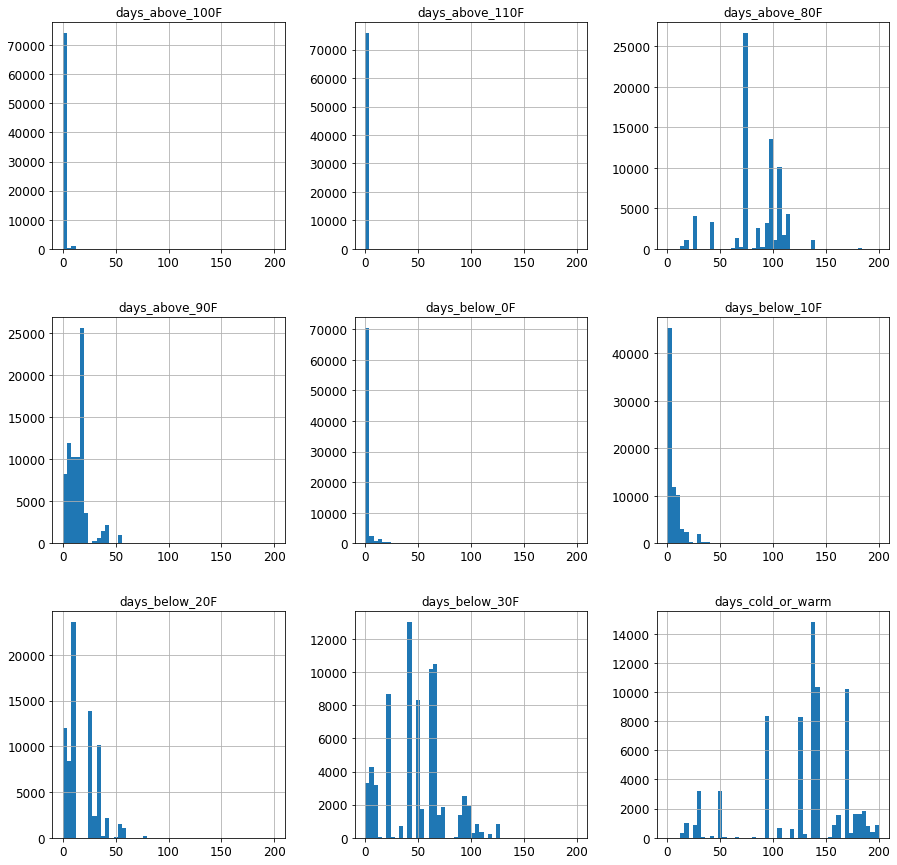

In [110]:
df.loc[:,days_cats + ['days_cold_or_warm']].hist(bins=50, range=(0,200), figsize=(15,15))
plt.show()

,site_eui,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,days_cold_or_warm
site_eui,1.000000,0.139811,0.119492,0.084296,0.060981,0.086347,-0.007980,-0.050029,-0.014190,0.132677
days_below_30F,0.139811,1.000000,0.896062,0.759727,0.452094,0.481902,0.030705,-0.167668,-0.023420,0.873611
days_below_20F,0.119492,0.896062,1.000000,0.904578,0.581687,0.449985,-0.010827,-0.140310,-0.020101,0.792901
days_below_10F,0.084296,0.759727,0.904578,1.000000,0.791753,0.266115,-0.034335,-0.084168,-0.011873,0.608170
days_below_0F,0.060981,0.452094,0.581687,0.791753,1.000000,0.034747,0.013618,-0.037509,-0.005205,0.293257
days_above_80F,0.086347,0.481902,0.449985,0.266115,0.034747,1.000000,0.681961,0.303567,0.093944,0.847388
days_above_90F,-0.007980,0.030705,-0.010827,-0.034335,0.013618,0.681961,1.000000,0.596418,0.212910,0.397344
days_above_100F,-0.050029,-0.167668,-0.140310,-0.084168,-0.037509,0.303567,0.596418,1.000000,0.622083,0.066987
days_above_110F,-0.014190,-0.023420,-0.020101,-0.011873,-0.005205,0.093944,0.212910,0.622083,1.000000,0.037981
days_cold_or_warm,0.132677,0.873611,0.792901,0.608170,0.293257,0.847388,0.397344,0.066987,0.037981,1.000000


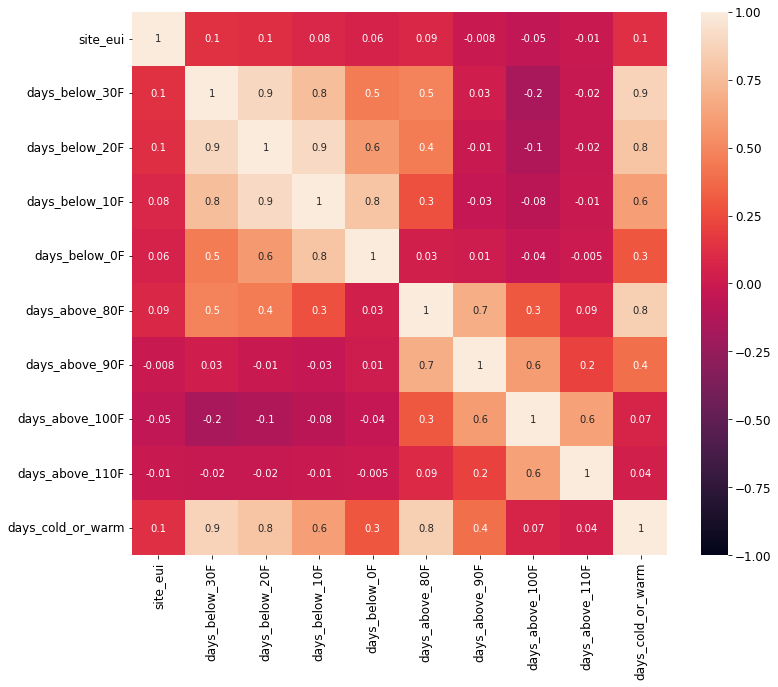

In [111]:
corr = df.corr().loc[['site_eui']+days_cats+['days_cold_or_warm'],['site_eui']+days_cats+['days_cold_or_warm']]
#corr
#print(type(corr_matrix))
plt.figure(figsize=(12,10))
heatmap = sns.heatmap(corr, annot=True, fmt='.1g', annot_kws={"fontsize":10}, vmin=-1, vmax=1, 
                      #xticklabels=list(df_prepared.columns), yticklabels=list(df_prepared.columns)
                     )
#heatmap.get_figure()
corr

##### Considerations

- for extreme temperatures, these distributions can be very skewed to low values, for middle temperatures they have one or two modes distributions
- the correlation with the site_eui is generally **not very strong**,  there are strong internal correlations between these parameters; it is worth **considering to drop some of them**
- no missing values
- since we don't have significant outliers, we can apply **min-max** scaling


#### Cooling degrees / heating degrees
(C)(NUM) `cooling_degree_days`: cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit (~18° C). Each month is summed to produce an **annual total** at the location of the building.

(C)(NUM) `heating_degree_days`: heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit (~18° C). Each month is summed to produce an **annual total** at the location of the building.


In [112]:
df[['cooling_degree_days','heating_degree_days']].describe()

,cooling_degree_days,heating_degree_days
count,75757.000000,75757.000000
mean,1202.250446,4324.957390
std,391.561780,824.366727
min,0.000000,398.000000
25%,1128.000000,3978.000000
50%,1277.000000,4337.000000
75%,1489.000000,4670.000000
max,4948.000000,7929.000000


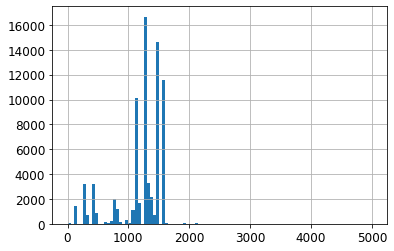

In [113]:
df['cooling_degree_days'].hist(bins=100,range=(0,5000))

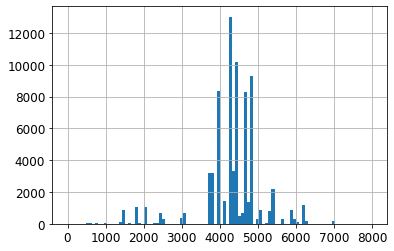

In [114]:
df['heating_degree_days'].hist(bins=100,range=(0,8000))

In [115]:
df['coolheat_degree_days'] = df['heating_degree_days'] + df['cooling_degree_days']

In [116]:
df.corr().loc[['site_eui','cooling_degree_days','heating_degree_days', 'coolheat_degree_days'],['site_eui','cooling_degree_days','heating_degree_days','coolheat_degree_days']]

,site_eui,cooling_degree_days,heating_degree_days,coolheat_degree_days
site_eui,1.000000,0.125004,0.147861,0.170430
cooling_degree_days,0.125004,1.000000,0.266273,0.609607
heating_degree_days,0.147861,0.266273,1.000000,0.926407
coolheat_degree_days,0.170430,0.609607,0.926407,1.000000


##### Considerations
- outliers not terrible, but also not great => could use standardisation for scaling
- no missing values
- moderate correlation with the target, useful information
- possible added feature: cooling + heating degree days, better correlation with target, of course, it's highly correlated with the single features

#### Precipitation and snow depth

(C)(NUM) `precipitation_inches`: annual precipitation in inches at the location of the building

(C)(NUM) `snowfall_inches`: annual snowfall in inches at the location of the building

(C)(NUM) `snowdepth_inches`: annual snow depth in inches at the location of the building

In [117]:
prec_cats = ['precipitation_inches', 'snowfall_inches', 'snowdepth_inches']
df.loc[:,prec_cats].describe()

,precipitation_inches,snowfall_inches,snowdepth_inches
count,75757.000000,75757.000000,75757.000000
mean,42.430651,29.136379,164.862455
std,10.592205,17.810894,175.275869
min,0.000000,0.000000,0.000000
25%,39.350000,9.600000,10.000000
50%,42.170000,31.600000,101.000000
75%,46.320000,49.100000,377.000000
max,107.690000,127.300000,1292.000000


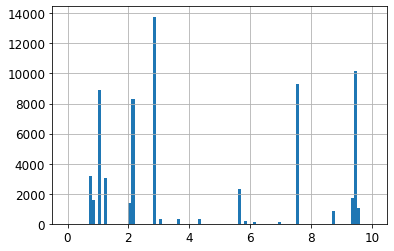

In [118]:
df['ratio'] = df['snowdepth_inches'].div(df['snowfall_inches'])
#df['ratio'].isinf()
df['ratio'].hist(bins=100, range=(0,10))

In [119]:
df.loc[df['snowdepth_inches']==1292].T.tail(20)

,2404
days_above_90F,0
days_above_100F,0
days_above_110F,0
direction_max_wind_speed,NaN
direction_peak_wind_speed,NaN
max_wind_speed,NaN
days_with_fog,NaN
site_eui,42.984
id,2404
log_ELEVATION,3.58352


In [120]:
df.loc[:,prec_cats].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   precipitation_inches  75757 non-null  float64
 1   snowfall_inches       75757 non-null  float64
 2   snowdepth_inches      75757 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 1.7 MB


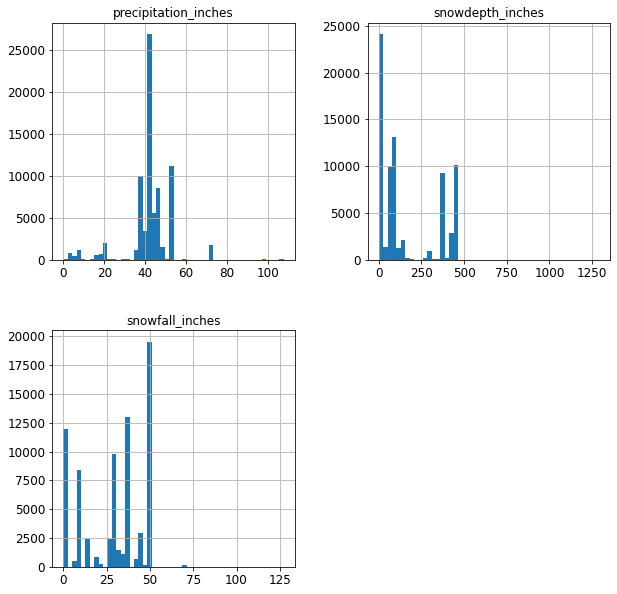

In [121]:
df.loc[:,prec_cats].hist(bins=50,figsize=(10,10))
plt.show()

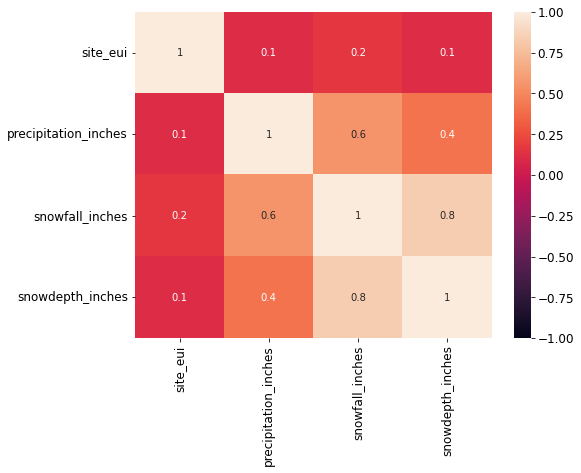

In [122]:
corr = df.corr().loc[['site_eui']+prec_cats, ['site_eui']+prec_cats]

plt.figure(figsize=(8,6))
heatmap = sns.heatmap(corr, annot=True, fmt='.1g', annot_kws={"fontsize":10}, vmin=-1, vmax=1, 
                     )

##### Considerations
- some outliers especially for snowdepth => standardisation
- wondering if the values for snow depth are reasonable: can in one year fall 38 meters of snow? it seems a bit unreasonable
- the ratio between snow depth and snow fall ranges between ~1-10: again is it reasonable?
- no missing values
- **moderate correlation** with target, useful information to keep, maybe **some redundancy** between snowdepth and snowfall inches

#### Wind & Fog features


direction_max_wind_speed: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

direction_peak_wind_speed: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

max_wind_speed: maximum wind speed at the location of the building

days_with_fog: number of days with fog at the location of the building



In [123]:
wind_fog_features = ['direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog' ]

In [124]:
df[wind_fog_features].info() # high numbers of missing values , compared to 75757

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   direction_max_wind_speed   34675 non-null  float64
 1   direction_peak_wind_speed  33946 non-null  float64
 2   max_wind_speed             34675 non-null  float64
 3   days_with_fog              29961 non-null  float64
dtypes: float64(4)
memory usage: 2.3 MB


In [125]:
for var in wind_fog_features:
  print('\n')
  print(df[var].value_counts())
  
# most non-null values have direction 1 degree and speed 1 (?)



1.0      27724
330.0     3011
310.0     2439
360.0      925
350.0      485
320.0       49
280.0       22
270.0       12
300.0        7
340.0        1
Name: direction_max_wind_speed, dtype: int64


1.0      27699
340.0     2931
360.0     1446
310.0     1260
320.0      491
330.0      104
270.0       12
350.0        3
Name: direction_peak_wind_speed, dtype: int64


1.0     27724
18.3     3096
13.0     1260
17.0      934
19.2      695
13.4      489
17.4      317
20.6       81
23.3       48
12.5       12
10.7        4
15.7        4
21.5        4
17.9        3
19.7        3
16.5        1
Name: max_wind_speed, dtype: int64


131.0    5386
99.0     4287
148.0    2614
56.0     2216
106.0    1967
79.0     1854
12.0     1761
110.0    1529
93.0     1442
104.0    1097
267.0     765
111.0     691
116.0     635
261.0     620
88.0      576
63.0      488
65.0      482
73.0      327
176.0     316
101.0     237
311.0     143
87.0       98
161.0      95
114.0      65
31.0       60
125.0      48
58.0    

In [126]:
df['direction_max_wind_speed'].value_counts()

1.0      27724
330.0     3011
310.0     2439
360.0      925
350.0      485
320.0       49
280.0       22
270.0       12
300.0        7
340.0        1
Name: direction_max_wind_speed, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb3847b0a30>,
      dtype=object)

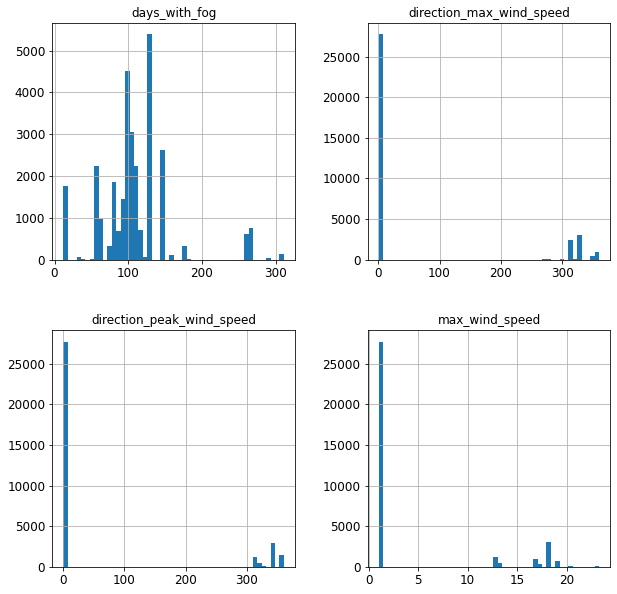

In [127]:
df[wind_fog_features].hist(bins=50, figsize=(10,10))

In [128]:
corr = df.corr()
corr.loc[['site_eui'] + wind_fog_features,['site_eui'] + wind_fog_features]




,site_eui,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
site_eui,1.000000,0.010217,0.013589,0.010639,-0.055388
direction_max_wind_speed,0.010217,1.000000,0.999784,0.988797,0.330441
direction_peak_wind_speed,0.013589,0.999784,1.000000,0.992227,0.330064
max_wind_speed,0.010639,0.988797,0.992227,1.000000,0.353990
days_with_fog,-0.055388,0.330441,0.330064,0.353990,1.000000


##### Considerations

- wind direction and speed information have little correlation with site_eui, as expected; given the skewness of distributions and the low fraction of meaningful values (effectively about 8% in the training set), we think of dropping this information
- days_with_fog:
  - distribution is ~bell-shaped with ok outliers
  - has about **60% missing values**
  - has a 5% correlation with the target (for the values that exist), which would go down if we were to input the value
  - probably better to drop this feature as well

### Check for duplicates

In [88]:
subset_for_duplicates = [
       'Year_Factor', 'State_id', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog'
]
# all initial features except site_eui, and id

In [98]:
abs(len(df.drop_duplicates(subset=subset_for_duplicates)) / len(df) - 1)

0.005029238222210464

In [99]:
abs(len(df_test.drop_duplicates(subset=subset_for_duplicates)) / len(df_test) - 1)

0.0005151983513652647

There is a small percentage of events with duplicated values. I noticed that these cases correspond to a capped energy rating.

I also noticed that there some other duplicates (of which the previous exmaples are a subset) where we have a double reading for the site_eui and the energy_rating , while all other characteristics are the same: 

In [100]:
subset_for_duplicates_no_energy_rating = [x for x in subset_for_duplicates if x!='energy_rating']

In [101]:
abs(len(df.drop_duplicates(subset=subset_for_duplicates_no_energy_rating)) / len(df) - 1)

0.005029238222210464

In [102]:
abs(len(df_test.drop_duplicates(subset=subset_for_duplicates_no_energy_rating)) / len(df_test) - 1)

0.0005151983513652647

Maybe there were more than one reading per year, or maybe there were very similar buildings in the same neibourhood, which were constructed in the same year and with same floor area, but distinct buildings in fact.. 
but how do we pick up the correct preceding reading for these cases? 